In [2]:
import lightkurve as lk
import numpy as np
import dynesty
import corner
import scipy 
import pandas as pd
import seaborn as sns

from functools import partial
import jax.numpy as jnp
from jax import jit

## Read in the APOKASC catalogue

https://www.dropbox.com/s/k33td8ukefwy5tv/APOKASC2_Table5.txt?dl=0;

In [3]:
sfile = '../data/APOKASC2_Table5.txt'
df = pd.read_csv(sfile, sep='\t')
df = df.loc[df.Teff > 10]
df = df.loc[df.Dnu > 10]
df = df[['KIC', 'Dnu', 'Nmax', 'Teff']]
df.head()

,KIC,Dnu,Nmax,Teff
14,1296507,10.310,126.833,4944.5
16,1431059,13.668,170.839,4825.5
21,1433803,12.160,150.192,4725.7
23,1569842,11.765,134.403,4799.7
32,1719422,11.312,135.434,4945.3


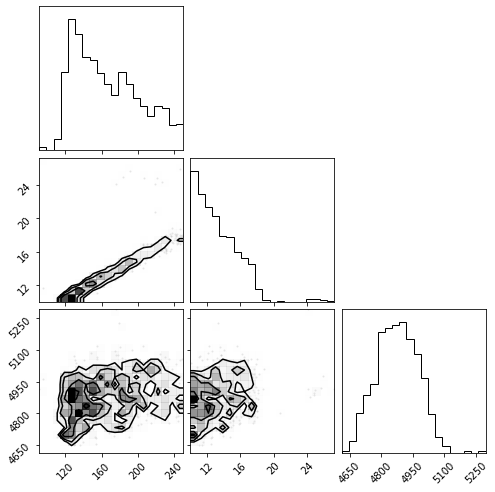

In [4]:
corner.corner(df[['Nmax', 'Dnu', 'Teff']]);

In [9]:
class dtwoterm():
    ''' At some point should JAX '''
    def __init__(self, pg):
        self.pg = pg
        self.f = self.pg.frequency.value
        self.O = self.pg.power.value
        self.O = self.O[len(self.f) % 4:]
        self.f = self.f[len(self.f) % 4:]
        self.f_dash = np.arange(self.f[0], self.f[-1] * 2, self.f[1] - self.f[0])

        
    def harvey(self, a, b, c=4):
        return a**2 / b / (1 + (self.f_dash / b)**c)
    
    def eta(self):
        ''' TODO calculate just once ?!?'''
        x = jnp.pi * self.f_dash / 2 / self.f.max()
        return np.sin(x) / x
    
    def hump(self, numax, width, height):
        return height * jnp.exp(-0.5 * (self.f_dash - numax)**2 / width**2)
    
    def model(self, p): 
        a1, b1, a2, b2, numax, width, height, white = p
        mod = (self.harvey(a1, b1) + self.harvey(a2, b2) + self.hump(numax, width, height)) * self.eta()**2 + white
        return jnp.abs(mod[:len(self.f)] + mod[-1:len(mod) - len(self.f) - 1:-1])
    
    def expand(self, l):
        ''' From Kalinger 2014'''
        numax, white, delta_a1, delta_a2, delta_width, delta_height = l 
        p = [delta_a1 * 3382 * numax**-0.609, 
             0.317 * numax**0.970, 
             delta_a2 * 3382 * numax**-0.609, 
             0.948 * numax**0.992,
             numax, 
             delta_width * 0.3 * numax **0.8, 
             delta_height * 3335 * numax**-0.564, 
             white]
        return p
    
    def full_model(self, l):
        return self.model(self.expand(l))
    
    @partial(jit, static_argnums=0)
    def loglike(self, l): 
        M = self.full_model(l)
        return -0.5 * jnp.sum(jnp.log(M) + self.O/M)
    
    def ptform(self, u): 
        return [u[0] * 300, 
                u[1] * np.median(self.O[-100:-1]),
                scipy.stats.norm.ppf(u[2]) * 0.3  + 1,
                scipy.stats.norm.ppf(u[3]) * 0.3  + 1,
                scipy.stats.norm.ppf(u[4]) * 0.5  + 1,
                scipy.stats.norm.ppf(u[5]) * 0.5  + 1]
    
    def __call__(self): 
        self.sampler = dynesty.NestedSampler(self.loglike, self.ptform, 6,
                               nlive=100)
        self.sampler.run_nested()
        res = self.sampler.results
        
        samples, weights = res.samples, np.exp(res.logwt - res.logz[-1])
        new_samples = dynesty.utils.resample_equal(samples, weights)
        return new_samples
        

class tutor():
    def __init__(self, df, plot=True):
        ''' 
        df: DataFrame 
            Contains the list of the targets with some information that might be useful
        
        '''
        self.df = df
        self.plot = plot
        self.output_file = 'learnt.csv'
        self.labels = ['KIC', 'Numax', 'White', 'd1', 'd2', 'd3', 'Height']
        try:
            self.output_df = pd.read_csv(self.output_file)
        except:
            self.output_df = pd.DataFrame(columns=self.labels)
        
        
    def pick_one(self): 
        return self.df.sample()
    
    def start(self):
        self.target = self.pick_one()
        print(self.target)
        
    def get_target_data(self):
        self.lc = lk.search_lightcurve('KIC ' + str(self.target.KIC.values[0]), author="Kepler", 
                                  quarter=[6,7,8,9,10], cadence="long").download_all().stitch()
        self.lc = self.lc.normalize()
        self.lc.flux *= 1e6
        self.pg = self.lc.to_periodogram(oversample_factor=1, normalization='PSD')
        if self.plot:
            self.plot_guess()
            
    def plot_guess(self):
        self.fit = dtwoterm(self.pg)
        ax = self.pg.plot('log')
        ax.plot(self.pg.frequency, self.pg.smooth(filter_width=2.0).power)
        ax.plot(self.fit.f, self.fit.full_model([self.target.Nmax.values[0], 
                                                 np.median(self.fit.O[-100:-1]) / 2, 
                                                 1., 1., 1., 1.]))
        ax.set_xlim([10, 288])
            
    def fit_target_data(self):
        self.fit = dtwoterm(self.pg)
        self.samples = self.fit()
        if self.plot:
            corner.corner(self.samples)
            self.posterior_pred_plot()
            
    def posterior_pred_plot(self):
        ax = self.pg.plot('log')
        ax.plot(self.pg.frequency, self.pg.smooth(filter_width=2.0).power)
        ax.plot(self.pg.frequency, self.pg.smooth(filter_width=20.0).power)
        for i in range(100):
            ax.plot(self.fit.f, self.fit.full_model(self.samples[i, :]), c='r', alpha=0.05)
        ax.set_xlim(10, 288)
        
    def save_summary_stats(self, output): 
        print(output)
        nd = [[i, *output[i]] for i in output]
        tmp = pd.DataFrame(columns=self.labels, data=nd)
        tmp.to_csv(self.output_file, index=False)
        
        
    def run_n(self, n):
        output = {}
        for i in range(n):
            self.start()
            self.get_target_data()
            self.fit_target_data()
            output[self.target.KIC.values[0]] = np.mean(self.samples, axis=0)
        self.save_summary_stats(output)
        

In [ ]:
apo = tutor(df)
apo.run_n(10)

          KIC     Dnu     Nmax    Teff
1691  5600739  14.386  187.232  4854.8


2457it [00:28, 87.59it/s, +100 | bound: 115 | nc: 1 | ncall: 21966 | eff(%): 11.694 | loglstar:   -inf < -37263.312 <    inf | logz: -37285.528 +/-    nan | dlogz:  0.001 >  0.109]


          KIC     Dnu     Nmax    Teff
1877  5869538  15.541  201.383  5014.4


1903it [00:22, 83.63it/s, +100 | bound: 91 | nc: 1 | ncall: 18706 | eff(%): 10.765 | loglstar:   -inf < -33620.562 <    inf | logz: -33637.258 +/-    nan | dlogz:  0.001 >  0.109]


          KIC    Dnu     Nmax    Teff
3446  8256020  11.36  138.379  4835.4


2000it [00:22, 87.10it/s, +100 | bound: 91 | nc: 1 | ncall: 19038 | eff(%): 11.089 | loglstar:   -inf < -32575.516 <    inf | logz: -32593.188 +/-  0.292 | dlogz:  0.001 >  0.109]


          KIC     Dnu    Nmax    Teff
1696  5610200  11.646  95.413  4961.2


2130it [02:51, 12.42it/s, +100 | bound: 690 | nc: 1 | ncall: 119394 | eff(%):  1.869 | loglstar:   -inf < -34218.398 <    inf | logz: -34237.359 +/-    nan | dlogz:  0.001 >  0.109]


          KIC     Dnu     Nmax    Teff
1746  5693454  10.894  122.796  4811.3


341it [00:02, 61.70it/s, bound: 0 | nc: 29 | ncall: 2458 | eff(%): 13.873 | loglstar:   -inf < -34542.848 <    inf | logz: -34551.423 +/-    nan | dlogz: 469.457 >  0.109] 